In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
from IPython.display import clear_output
import lloyds
from poisson_disc import Grid
from labels import project_positions,create_label
from ase import Atoms,Atom
from pyqstem import PyQSTEM
from pyqstem.imaging import CTF
from pyqstem.util import atoms_plot
import matplotlib.pyplot as plt
import matplotlib.path as mplPath
from scipy.spatial import Voronoi,KDTree
from ase.io import write,read
from ase.build import graphene_nanoribbon
import scipy.spatial
from ase.visualize import view
import collections #For at kunne bruge stack

#Dele fra graphene
from glob import glob

import os,sys,inspect #Bruges for at den kan importere temn
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
from temnn.net.dataset import DataSet, DataEntry

In [2]:
def lookup_nearest(x0, y0, x, y, z):
    xi = np.abs(x-x0).argmin()
    yi = np.abs(y-y0).argmin()
    return z[yi,xi]

def interpolate_smoothly(points, N):
    half = (len(points) + 1) // 2
    F = np.fft.fft(points)
    F = np.hstack((F[:half],[0]*(len(F)*N),F[half:]))
    return np.fft.fft(F)[::-1].real / len(points)


def blob(N=10,M=50):
    points=np.array([np.random.rand(N),np.random.rand(N)]).T
    points=points[scipy.spatial.ConvexHull(points).vertices]
    points=np.array([interpolate_smoothly(p, M) for p in zip(*points)]).T
    return points-np.mean(points,axis=0)

#Den her funktion bliver ikke brugt nogle steder :/
def strain(positions,direction,cell,power=-3,amplitude=10**3,N=(64,64)):
    noise=spectral_noise.power_law_noise(N,power)
    x=np.linspace(0,cell[0],N[0])
    y=np.linspace(0,cell[1],N[1])

    positions[:,direction]+=amplitude*np.array([lookup_nearest(p[0], p[1], x, y, noise) for p in positions]).T
    
    return positions

def random_sheet(cell,r):
    
    grid = Grid(r, cell[0], cell[1])
    
    rand = (np.random.uniform(0, cell[0]), np.random.uniform(0, cell[1]))
    positions = grid.poisson(rand)
    
    positions=lloyds.repeat(positions,cell[:2])
    positions=lloyds.repeat(positions,cell[:2])
    positions=lloyds.repeat(positions,cell[:2])
    
    vor=Voronoi(positions)
    
    positions=vor.vertices
    
    positions=positions[positions[:,0]<cell[0]]
    positions=positions[positions[:,0]>0]
    positions=positions[positions[:,1]<cell[1]]
    positions=positions[positions[:,1]>0]
    
    positions=lloyds.relax(positions,cell[:2],num_iter=1,bc='periodic')
    positionsHoles = np.copy(positions) #Laver en kopi som skal bruges til at lave huller
    
    #Laver hullerne
    num_holes=np.random.randint(0,3)
    for i in range(num_holes):
        size=(.4+.6*np.random.rand())*cell[0]
        hole=size*blob()+[np.random.uniform(0, cell[0]), np.random.uniform(0, cell[1])]
        contained = mplPath.Path(hole).contains_points(positionsHoles)
        positionsHoles = positionsHoles[np.where(contained==0)[0]]
    
    positions=positionsHoles
    positions=np.hstack((positions,np.array([[0]*len(positions)]).T))
    
    atoms=Atoms(['C']*len(positions),positions*1.2)
    atoms.set_cell(cell)
    atoms.set_positions(positions)
    atoms.set_pbc(1)
    atoms.wrap()
    atoms.center()
    
    atoms = ChangeAtoms(atoms) #Kører udtrykket der ændre atomer
    
    print(len(atoms), len(atoms)/(cell[0]*cell[1]),2/5.24)
    
    return atoms

def load(data_dir):
    
    waves=glob(data_dir+"wave/wave_*.npz")
    labels=glob(data_dir+"label/label_*.npy")
    points = sorted(glob(data_dir+"points/points_*.npz"))

    entries=[DataEntry(wave=w,points=p) for w,p in zip(waves,points)]
    
    return DataSet(entries)

def ChangeAtoms(atoms):
    
    sites = atoms.get_positions() #Får et array med hvad der er
    newtypes = np.zeros(len(atoms))
    
    stack = collections.deque() #Laver stacken
    neighborlist = KDTree(sites) 
    _, pos = neighborlist.query(atoms.get_cell().diagonal() / 2, 1) #Gets the length and index (iAtom) for the 4 nearest atom
    stack.append([pos, 42]) # Start by requesting atom 0 to be Mo
    t=0
    while len(stack)>0:
        pos, AtomType = stack.pop() #Takes the first entrys position and type 
    
        if newtypes[pos] == 0 :
            #Fjerner det C atom som var der før
            newtypes[pos] = AtomType
            lAtom, iAtom = neighborlist.query(sites[pos],k=4)  # Three neighbors and itself
            # The first is the atoms itself, the second its closest neighbor
            cutoff = 0.5 * lAtom[1]

            for i in range(4):
                if newtypes[iAtom[i]] == 0:  # and lAtom[i] < cutoff:
                    if AtomType == 42:
                        stack.appendleft([iAtom[i], 16])
                    else:
                        assert(AtomType == 16)
                        stack.appendleft([iAtom[i], 42])
                        
        if len(stack) == 0: #Tjekker efter om den er færdig, og så om den mangler nogle atomer
            if (0 in newtypes) == True:
                stack.appendleft([np.argmin(newtypes), 42]) #Finder index hvor der er et 0, sætter det til 42 i stacken
            
    atoms.set_atomic_numbers(newtypes) #Indsætter værdierne for atomerne fra arrayet
    
    #Den del som laver det enkelte S om til to S som  er forskudt med dz
    dz = 0.625 #Standard er 0.5
    sites = atoms.get_positions()
    NewS = Atoms() #Tom atoms som bruges til at indsætte de nye svovl atomer, uden at påvirker det gamle
    
    for i in range(len(sites)):
        if atoms.get_atomic_numbers()[i] == 16:
            sites[i][2] = sites[i][2]+dz
            NewS+=Atom('S',position=sites[i]+[0,0,-dz*2])
            
    atoms.set_positions(sites) #Indsætter deres nye positioner ind i den.
    atoms+=NewS #Tilføjer de nye svovl atomer
    
    return atoms

In [3]:
N=360
sampling=24.48/2048*10
L=sampling*N
cell=(L,L,5)

#mos2=random_sheet(cell,1.9) #Henter hvordan det ser ud (cell,r)
#view(mos2) 

In [4]:
num_examples=1
#num_examples=len(examples)

dir_name='../data/mos2-training-classes-3/'
first_number=0
label_size=(N,N)

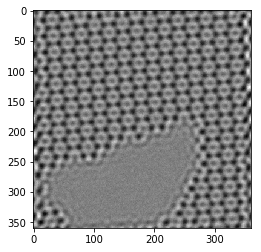

In [5]:
#Samme som før, men med random elementer (i stedet for konstant)
sampling=24.48/2048*10
Cs=np.random.uniform(-20,20)*10**4
defocus=np.random.uniform(-200,200)
focal_spread=np.random.uniform(25,50)

#Nye elementer, til ctf og create image
aberrations={'a22':np.random.uniform(0,50),'phi22':np.random.rand()*2*np.pi,}
dose=10**np.random.uniform(4,6)
mtf_param=[1,np.random.uniform(0,.1),np.random.uniform(0.4,.6),np.random.uniform(2,3)]
blur=np.random.uniform(0,2)

data = load(dir_name)
entry=data.next_batch(1)[0]

entry.reset()
entry.load()
ctf=CTF(defocus=defocus,Cs=Cs,focal_spread=focal_spread,aberrations=aberrations)
entry.create_image(ctf,sampling,blur,dose,mtf_param)
entry.create_label(sampling, width = int(0.4/sampling), num_classes=2) #Sæt den til num_classes og 

#entry.crop(crop)

image,label,sites,classes=entry.as_tensors(return_all=True) #Den her forstår jeg ikke 

plt.imshow(image[0,:,:,0],cmap='gray')

In [6]:
print(image.shape, label.shape)
print(sites.shape)
print(classes.shape)
print(classes.mean())

(1, 360, 360, 1) (1, 360, 360, 3)
(318, 2)
(318,)
0.5062893081761006


(1, 360, 360, 1) (1, 360, 360, 3)
[0 0 0 1 0 1 0 0 1 0 1 0 1 0 0]


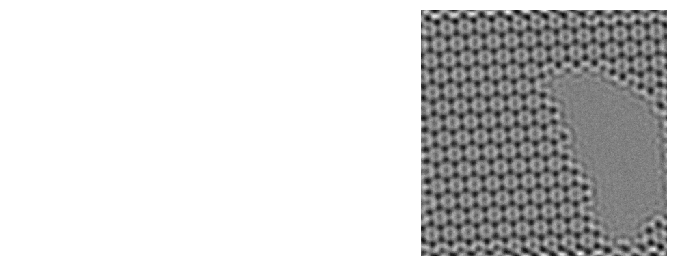

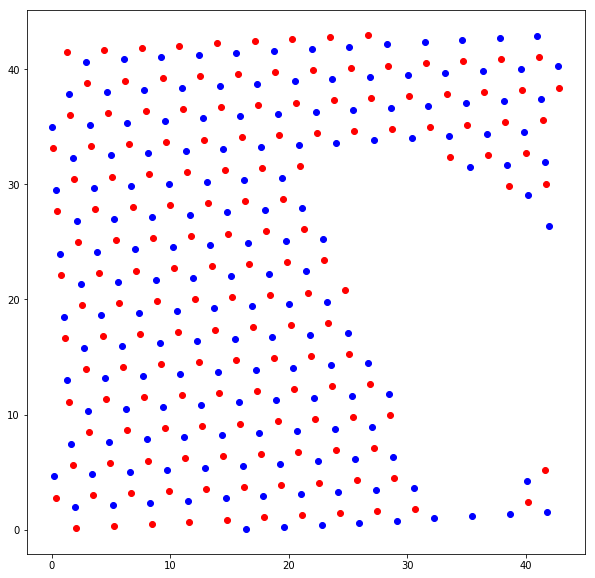

In [7]:
#ctf=CTF(defocus=defocus,Cs=Cs,focal_spread=focal_spread,aberrations=aberrations)
#image=wave.apply_ctf(ctf).detect(resample=sampling)

print(image.shape,label.shape)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))

#atoms_plot(mos2)
ax1.axis('off')

ax2.imshow(np.flipud(image[0,:,:,0].T),cmap='gray');
ax2.axis('off')

#ax3.imshow(np.flipud(label[:,:,0].T))
#ax3.axis('off')

plt.tight_layout()


#Ekstra til når den gemmer points, wave etc....?
#Mos2_positions = mos2.get_positions()
#Atom_Numbers=mos2.get_atomic_numbers()

fig = plt.figure(figsize=(10,10))
print(classes[:15])
plt.plot(sites[classes==0][:,0], sites[classes==0][:,1], 'ro')
plt.plot(sites[classes==1][:,0], sites[classes==1][:,1], 'bo')

#plt.savefig("hejsa.png")

In [8]:
entry

In [9]:
data